# CGA Strategy

### Two similar pubs in the same town centre, have good and similar rates of sale of draught Guinness pints.

##### One of the pubs decides to promote St Patrick's Day from Thursday 14th to Sunday 17th. The outlet hangs Guinness banners inside and outside of the pub, decorates the pub with themed decorations, and has leprechaun hats placed around the pub for consumers to wear.

##### You are asked to document and present your findings using the data provided.


### Import Packages

In [101]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.dates import DateFormatter
from datetime import datetime
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.formula.api import ols

### Import .xlsx to pandas dataframe and format

In [102]:
#%% Import .xlsx data using pandas
data = pd.read_excel(r'C:\Users\edmun\Downloads\CGA soultions Interview Task\task_cga.xlsx')
# format to create headers and remove empty columns
data.columns = data.iloc[1]
data = data.dropna(axis=1,how='all')
data = data.drop(data.index[[0,1]])
data = data.reset_index(drop=True)
# Convert date column to datetime format
data['date'] =  pd.to_datetime(data['date'], format='%Y%m%d %H:%M:%S') # '%d%b%Y:%H:%M:%S.%f'
# Convert 'serves' columns to numeric
data[['serves_sample','serves_control']] = data[['serves_sample','serves_control']].astype(int)

print(data)

1        date  serves_sample  serves_control
0  2019-03-01            250             254
1  2019-03-02            254             255
2  2019-03-03            173             168
3  2019-03-04            142             145
4  2019-03-05            145             143
5  2019-03-06            159             164
6  2019-03-07            177             175
7  2019-03-08            219             221
8  2019-03-09            234             229
9  2019-03-10            173             177
10 2019-03-11            142             140
11 2019-03-12            145             142
12 2019-03-13            159             157
13 2019-03-14            212             181
14 2019-03-15            268             215
15 2019-03-16            278             238
16 2019-03-17            173             172
17 2019-03-18            142             143
18 2019-03-19            145             149
19 2019-03-20            159             164
20 2019-03-21            177             174
21 2019-03

In [104]:
data.describe().transpose().head()

,count,mean,std,min,25%,50%,75%,max
1,,,,,,,,
serves_sample,31.0,189.935484,45.414341,142.0,152.0,173.0,234.0,278.0
serves_control,31.0,184.516129,39.182369,139.0,153.0,172.0,218.0,255.0


### Exploratory Data Analysis (EDA)

#### First plot data to observe any initial trends

(17954.5, 17987.5)


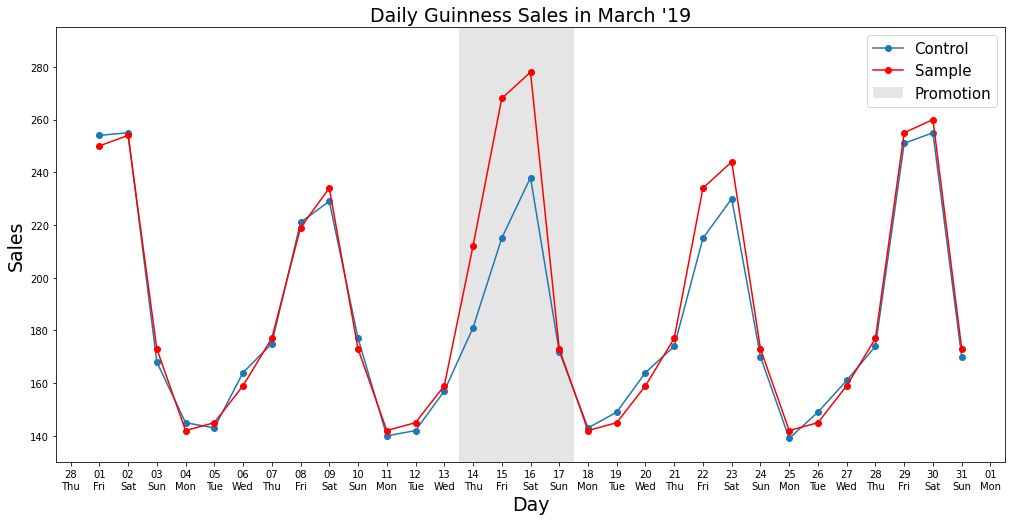

In [121]:
#%% 

plt.figure(figsize=(17, 8))
# points
plt.plot(data.iloc[:,0],data.iloc[:,2], marker = 'o', linestyle = 'solid', label = 'Control')
plt.plot(data.iloc[:,0],data.iloc[:,1], marker = 'o', linestyle = 'solid', color = 'r', label = 'Sample')

plt.title('''Daily Guinness Sales in March '19''', size = 19)
plt.ylabel('Sales', size = 19)
plt.xlabel('Day', size = 19)


# Show dates as just days of the month
ax = plt.gca()
# ax.xticks(np.arange(min(data['date']), max(data['date'])+1, 1.0))
dFormat = DateFormatter("%d\n%a")
ax.xaxis.set_major_formatter(dFormat)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
print(ax.get_xlim())
# #highlight weekends
# xmin, xmax = ax.get_xlim()
# days = np.arange(np.floor(xmin), np.ceil(xmax)+2)
# weekends = [(dt.weekday()>=5)|(dt.weekday()==0) for dt in mdates.num2date(days)]
# ax.fill_between(days-0.5, *ax.get_ylim(), where=weekends, facecolor='k', alpha=.1, label = 'Promotion')
ax.set_ylim(130, 295) # set limits back to default values
ax.axvspan(17968.5, 17972.5, facecolor='k', alpha=.1, label = 'Promotion')
plt.legend(loc="upper right", fontsize=15)

plt.show()

#### There appears to be single weekly seasonality in both time-series, and that it is likely additive for both.
#### Potentially Monthly Seasonality also present due to effect of payday 

## First, knowing the intervention, I want to see if there is a significant difference in the averages, despite the clear seasonality of the data

In [4]:
#%% Basic unpaired t-test sample vs control
stats.ttest_ind(data['serves_sample'],
                data['serves_control'])

Ttest_indResult(statistic=0.5030541413230766, pvalue=0.6167679339707555)

#### There is no statistically significant difference in the average guinness sales between sample and control pubs in March, t= 0.5031, p= 0.617.

In [5]:
#%% unpaired t-test of sales before and after promotion for sample
stats.ttest_ind(data.iloc[0:12, 1],
                data.iloc[13:30, 1])

Ttest_indResult(statistic=-0.6910098683064912, pvalue=0.4954579667674528)

#### There is no significant difference between guinness sales after the intervention (14th March) at the sample pub, t= -0.6910, p= 0.496.


## ACF Plot

### To reveal more details about the data without the intervention effect, an ACF plot of the control is used

C:\Users\edmun\AppData\Local\Programs\Python\Python39\opencv\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


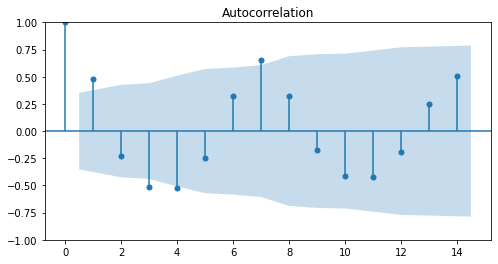

In [122]:
# series of serves data for both pubs, this format is to satisfy statsmodels functions (ACF + STL)
control = data[['date', 'serves_control']]
control.index = control['date']
control.drop(columns='date',inplace=True)
sample = data[['date', 'serves_sample']]
sample.index = sample['date']
sample.drop(columns='date',inplace=True)

with mpl.rc_context():
    mpl.rc("figure", figsize=(8,4))
    plot_acf(control, lags = 14)

### Serveral correlations indicate time-series is non-random
### Positive correlations at Lag 1 and Lag 7. Correlation at Lag 7 suggests weekly seasonality. No lag at 14 as well likely due to lack of data or influence of overarching monthly or non-seasonal trend

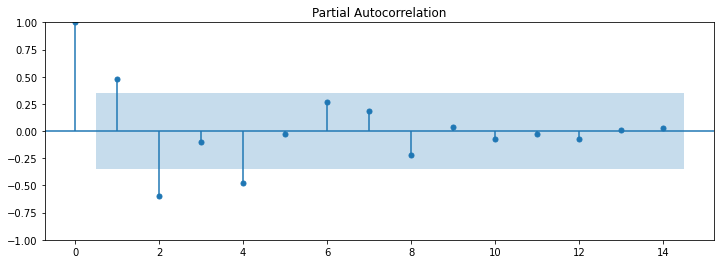

In [57]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(12,4))
    plot_pacf(control, lags = 14, method = "ywm")

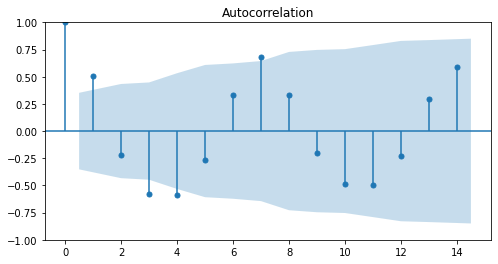

In [131]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(8,4))
    plot_acf(sample, lags = 14)

### Sample data shows a very similar plot further suggesting that these two groups are highly correlated


##  
## Explore data using STL Decomposition



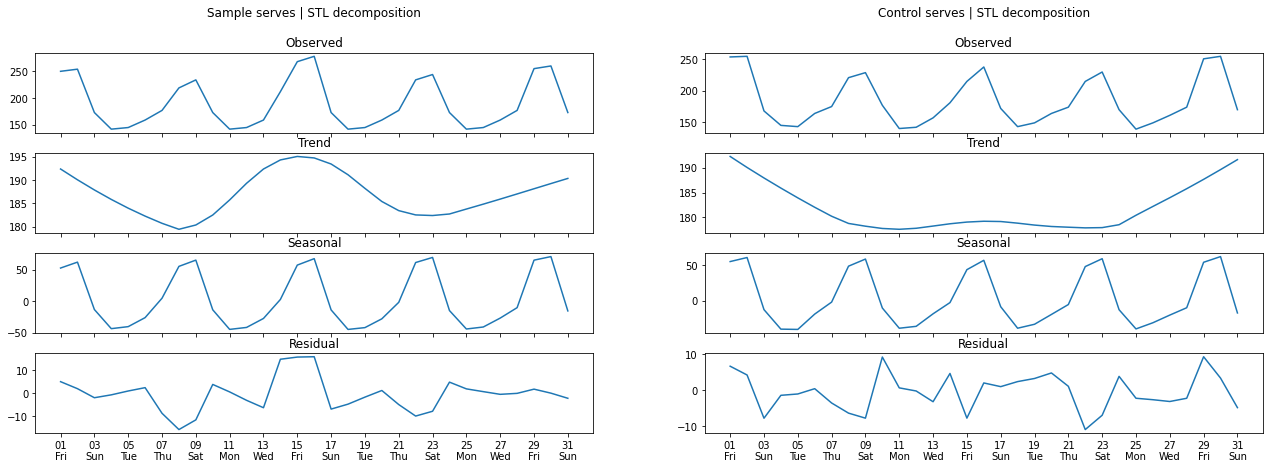

In [42]:
# STL decomp on control pub
STL_control = STL(control)
result = STL_control.fit()

seasonal, trend, resid = result.seasonal, result.trend, result.resid

# Create and fit STL decomp to sample pub
STL_sample = STL(sample)
result2 = STL_sample.fit()

#%%
seasonal2, trend2, resid2 = result2.seasonal, result2.trend, result2.resid

#%%
fig, (axs) = plt.subplots(4, 2, sharex=True, sharey=False, figsize=(22,7), \
gridspec_kw={'hspace': 0.25})

axs[0,0].set_title('Sample serves | STL decomposition\n\nObserved')
axs[0,0].plot(sample)
axs[0,0].xaxis.set_major_formatter(dFormat)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))

axs[1,0].set_title('Trend')
axs[1,0].plot(trend2)

axs[2,0].set_title('Seasonal')
axs[2,0].plot(seasonal2)

axs[3,0].set_title('Residual')
axs[3,0].plot(resid2)

axs[0,1].set_title('Control serves | STL decomposition\n\nObserved')
axs[0,1].plot(control)
axs[0,1].xaxis.set_major_formatter(dFormat)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))

axs[1,1].set_title('Trend')
axs[1,1].plot(trend)

axs[2,1].set_title('Seasonal')
axs[2,1].plot(seasonal)

axs[3,1].set_title('Residual')
axs[3,1].plot(resid)

# format x axis
plt.gca().xaxis.set_major_formatter(dFormat)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))

### STL decomposition confirms seasonality of sample & control pub data.

## Robust Anomoly Detection of Sample Pub

### If anomolies are detected during or after promotional period, this would indicate a significant effect not explained by the trend or seasonality

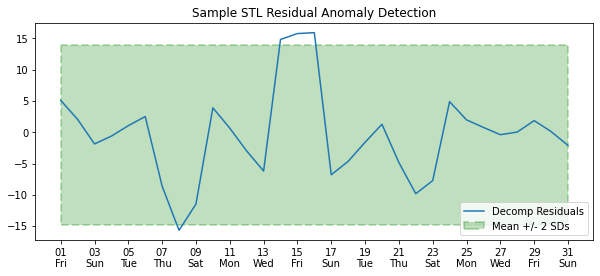

In [147]:
resid_mu2 = resid2.mean()
resid_dev2 = resid2.std()

lower = resid_mu2 - 2*resid_dev2
upper = resid_mu2 + 2*resid_dev2

plt.figure(figsize=(10,4))
plt.plot(resid2, label = 'Decomp Residuals')
plt.title('Sample STL Residual Anomaly Detection')

plt.fill_between([datetime(2019,3,1), datetime(2019,3,31)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2,
                 label = "Mean +/- 2 SDs")
plt.legend(loc="lower right", fontsize=10)

plt.gca().xaxis.set_major_formatter(dFormat)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))

# No anomolous data points
# Shows that there are no data points that are not explained by the trend

## Estimate decompsition of interaction

### Applying the Parallel trend assumption
### The STL decompositions of the control pub are subtracted from those of the sample to provide an estimation of the interaction effect

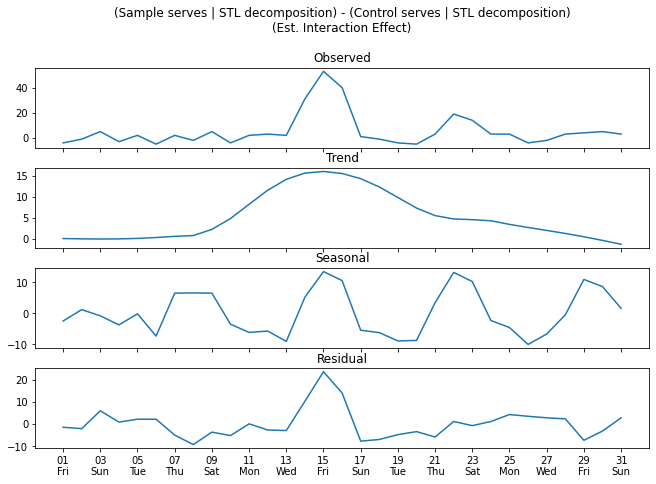

In [19]:
#%% STL but result 1 - result 2

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(11,7), \
gridspec_kw={'hspace': 0.25})

ax1.set_title('(Sample serves | STL decomposition) - (Control serves | STL decomposition)\n(Est. Interaction Effect)\
\n\nObserved')
ax1.plot(sample.rename(columns={'serves_sample':'serves_control'}).subtract(control))
ax1.xaxis.set_major_formatter(dFormat)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))

ax2.set_title('Trend')
ax2.plot(trend2 - trend)

ax3.set_title('Seasonal')
ax3.plot(seasonal2 - seasonal)

ax4.set_title('Residual')
ax4.plot(resid2 - resid)

plt.gca().xaxis.set_major_formatter(dFormat)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))

#### Interaction Effect is likely to have abrupt onset and temporary duration. It may also display seasonality. Due to incomparability of LOESS models and inaccuracy at low data frequencies, these models are for exploratory purposes only.

## Any effect by the intervention is too small to detect by t-test of sample data.

## Intervention Effect can be tested using difference-in-differences (DID), segmented regression of interrupted time series (ITS), and interventional autoregressive integrated moving average (iARIMA)

## If sample data and control data are strongly correlated, both groups can be incorparated into a Difference in Differences model can be used to test if the intervention had significant effect

In [149]:
#%% Pearson's correlation test (control to sample)
stats.pearsonr(data.iloc[:,1],data.iloc[:,2])

(0.9611636168719494, 9.299623628959857e-18)

#### There is a significant (p= 0.002) strong positive correlation (r= 0.998) between the increases and decreases in daily Guinness servings at the sample pub and the increases and decreases in daily Guinness servings at the control pub


## Difference in Differences:

In [74]:
#%% Difference in differences model
#   Assume that no time-varying differences exist between the sample and control groups
#   (Parallel trend assumption)

# Add before and after treatment boolean column (0 = before, 1= after)
data['post_treatment'] = np.zeros(31)
data.iloc[13:,3] = 1

# Recreate DID_data for pandas melting for regression
DID_data = data.iloc[:, [0, 1, 2, 3] ]
DID_data = DID_data.rename(columns={'serves_sample' : 'sample',
                                    'serves_control': 'control'})
DID_data = pd.melt(DID_data, id_vars =['date', 'post_treatment'], value_vars =['sample', 'control'],
              var_name ='pub', value_name ='serves')
# Convert pub to binary (control = 0, treatment group = 1)
DID_data['treatment_group'] = np.where(DID_data.pub=='sample',1,0)

# Columns to be used:
print(DID_data.head())

reg = ols('serves ~ treatment_group + post_treatment + treatment_group * post_treatment', data=DID_data).fit()
print(reg.summary())

        date  post_treatment     pub  serves  treatment_group
0 2019-03-01             0.0  sample     250                1
1 2019-03-02             0.0  sample     254                1
2 2019-03-03             0.0  sample     173                1
3 2019-03-04             0.0  sample     142                1
4 2019-03-05             0.0  sample     145                1
                            OLS Regression Results                            
Dep. Variable:                 serves   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.034
Method:                 Least Squares   F-statistic:                    0.3293
Date:                Mon, 30 Jan 2023   Prob (F-statistic):              0.804
Time:                        21:45:14   Log-Likelihood:                -318.91
No. Observations:                  62   AIC:                             645.8
Df Residuals:                      58   BIC:                             65

### Average difference in serves/day post-promotion at the sample pub is 9.06. However this effect is not significant (p = 0.683)

eval_env: 1


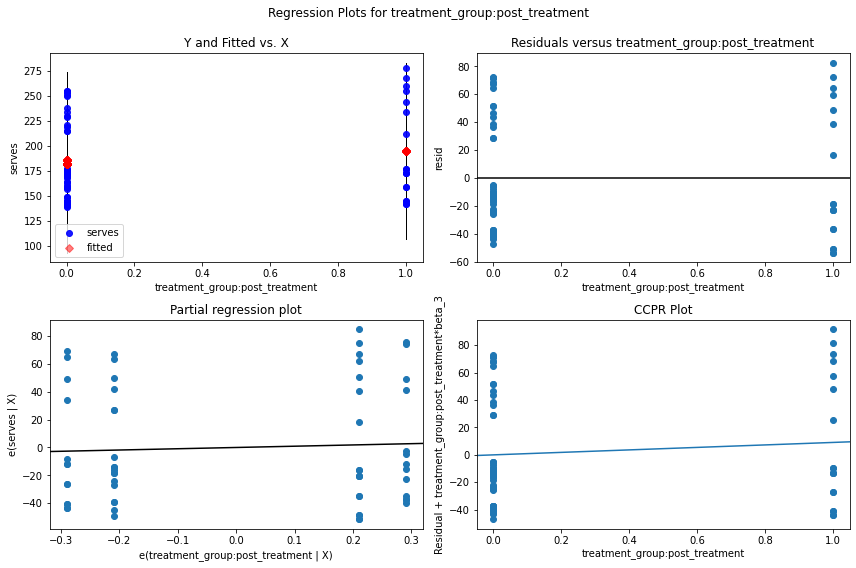

In [75]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(reg, 'treatment_group:post_treatment', fig=fig)


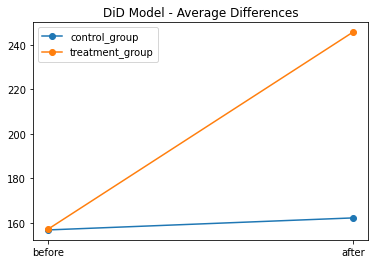

In [137]:
#%% Define parameters for average difference plots
b0,b1,b2,b3 = reg.params[0],reg.params[1],reg.params[2],reg.params[3]

# plot average differences plot
plt.plot(['before','after'],[b0   , b0+b2], label = 'control_group', marker = 'o')
plt.plot(['before','after'],[b0+b1, b0+b1+b2+b3], label = 'treatment_group', marker = 'o')
plt.title('DiD Model - Average Differences')
plt.legend()

## Model is likely skewed due to the effects of autocorrelation seen on ACF plot
## Crude addition of weekly seasonality to DiD model (fri/sat):

In [77]:
#%% weekend factor
DID_data['weekend'] = np.where((DID_data['date'].dt.day_name() =='Friday') |
                                (DID_data['date'].dt.day_name() =='Saturday'),1,0)
reg = ols('serves ~ treatment_group + post_treatment +  weekend\
          + treatment_group * post_treatment', data=DID_data).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 serves   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     86.32
Date:                Mon, 30 Jan 2023   Prob (F-statistic):           1.66e-23
Time:                        21:45:19   Log-Likelihood:                -258.85
No. Observations:                  62   AIC:                             527.7
Df Residuals:                      57   BIC:                             538.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

### Average difference in serves/day post-promotion at the sample pub is 9.06. However this effect is still not significant even though it decreased (p = 0.288)
### Though average difference in serves/day on fridays and saturdays compared to the rest of the week is 82.1 and significant (p < 0.001). Therefore it was appropriate to account for Fri/Sat in this model.

eval_env: 1


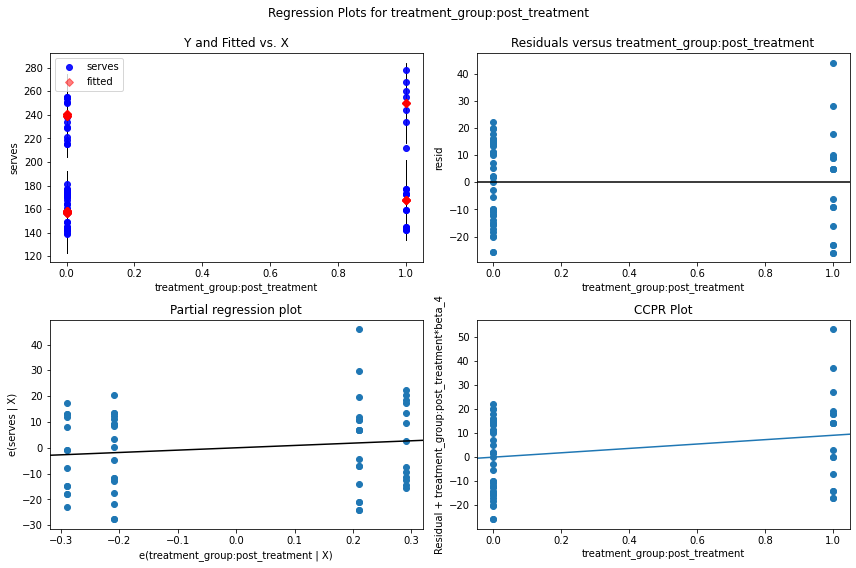

In [78]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(reg, 'treatment_group:post_treatment', fig=fig)


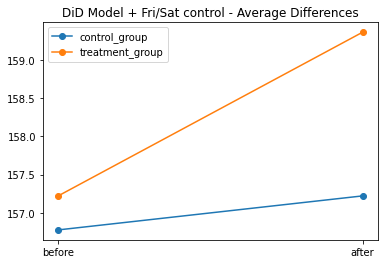

In [144]:
#%% Define parameters for average difference plots
b0,b1,b2,b3,b4 = reg.params[0],reg.params[1],reg.params[2],reg.params[4],reg.params[3]

# plot average differences plot
plt.plot(['before','after'],[b0   , b0+b1], label = 'control_group', marker = 'o')
plt.plot(['before','after'],[b0+b1, b0+b1+b3], label = 'treatment_group', marker = 'o')
plt.title('DiD Model + Fri/Sat control - Average Differences')
plt.legend()

## Addition of lag 1 autocorrelation to DiD model:

In [80]:
# create lag column
DID_data['lag1'] = DID_data['serves'].shift(1)
# remove NaN for 1 so first value is passive
DID_data = DID_data.fillna(1)
# turn 1st march value for control to 1
DID_data.at[31, 'lag1'] = 1

reg = ols('serves ~ treatment_group + post_treatment +  weekend + lag1\
          + treatment_group * post_treatment', data=DID_data).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 serves   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     71.80
Date:                Mon, 30 Jan 2023   Prob (F-statistic):           4.25e-23
Time:                        21:45:24   Log-Likelihood:                -257.34
No. Observations:                  62   AIC:                             526.7
Df Residuals:                      56   BIC:                             539.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

### Average difference in serves/day post-promotion at the sample pub is 20.9. However this effect is still not significant (p = 0.288)
### Average difference in serves/day on fridays and saturdays compared to the rest of the week is 83.0 and is not significant (p = 0.314). Therefore it was not appropriate to account for autocorrelation of 1st lag.

## Effect of intervention is potential seasonal (only effecting weekends) 
## Applying this to DiD model:

In [95]:
reg = ols('serves ~ treatment_group + post_treatment +  weekend\
          + treatment_group * post_treatment * weekend', data=DID_data).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 serves   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     49.70
Date:                Mon, 30 Jan 2023   Prob (F-statistic):           2.73e-21
Time:                        22:32:56   Log-Likelihood:                -257.20
No. Observations:                  62   AIC:                             530.4
Df Residuals:                      54   BIC:                             547.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

eval_env: 1


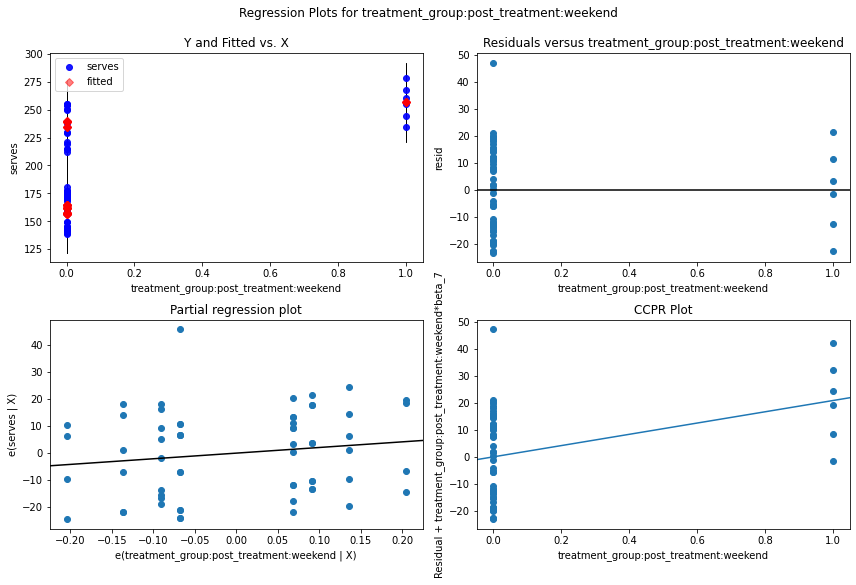

In [96]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(reg, 'treatment_group:post_treatment:weekend', fig=fig)

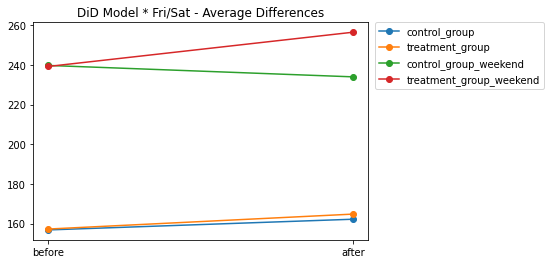

In [145]:
#%% Define parameters for average difference plots
b0,b1,b2,b3,b4,b5,b6,b7 = reg.params[0],reg.params[1],reg.params[2],reg.params[3],\
                            reg.params[4],reg.params[5],reg.params[6],reg.params[7]

#%% plot the average differences plot
plt.plot(['before','after'],[b0,b0+b2], label = 'control_group', marker = 'o')
plt.plot(['before','after'],[b0+b1,b0+b1+b2+b4], label = 'treatment_group', marker = 'o')
plt.plot(['before','after'],[b0+b3,b0+b2+b3+b6], label = 'control_group_weekend', marker = 'o')
plt.plot(['before','after'],[b0+b1+b3+b5,b0+b1+b2+b3+b4+b5+b6+b7], label = 'treatment_group_weekend', marker = 'o')
plt.title('DiD Model * Fri/Sat - Average Differences')
plt.legend(bbox_to_anchor=(1.02, 1),loc='upper left', borderaxespad=0)